*****************************************************************
#  Research paper
- Authors: Paul Koks, Izzie He, Lisanne van Vliet, Sam Slotemaker
- TAs: Sandro Barres-Hamers, Alexander Schmatz, Márton Bodó and Danae Mitsea.
*****************************************************************

## Installing the needed packages
The following 2 cells install and import the needed packages


In [ ]:
!pip install nltk

In [ ]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('subjectivity')
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import numpy as np

## Store all comments from the CSV files with their corresponding movie ID
This cell gets all data from the comment CSVs and puts it inside a map by its movie ID, so it can later be easily extracted

In [25]:
import csv
import os

directory = 'datasets/comments'
comments_by_movie_id = {}
for filename in os.listdir(directory):
    if filename.endswith('.csv'): 
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            csv_reader = csv.DictReader(file)
            data = [row for row in csv_reader]
            fileName = filename.split('.')[0];
            comments_by_movie_id[fileName] = data

print("All comments are parsed and now stored inside the comments_by_movie_id variable!")

All comments are parsed and now stored inside the comments_by_movie_id variable!


## Store the average sentiment of the trailer comments
This cell will analyse all comments and store their sentiment score

In [15]:
from collections import Counter

sentiment_by_movie_id = {}

for movieId, comments in comments_by_movie_id.items():
    sentiment_total = 0
    for comment in comments:
        sentence = comment['text']
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(sentence)
        sentiment_total += ss['compound']

    average_sentiment = sentiment_total / len(comments)
    sentiment_by_movie_id[movieId] = average_sentiment

print("All sentiments are analysed and stored inside the sentiment_by_movie_id variable!")

All sentiments are analysed and stored inside the sentiment_by_movie_id variable!


## Analisys
The cell below takes our 40 movies, then, for every movie it plots it against the sentiment number 

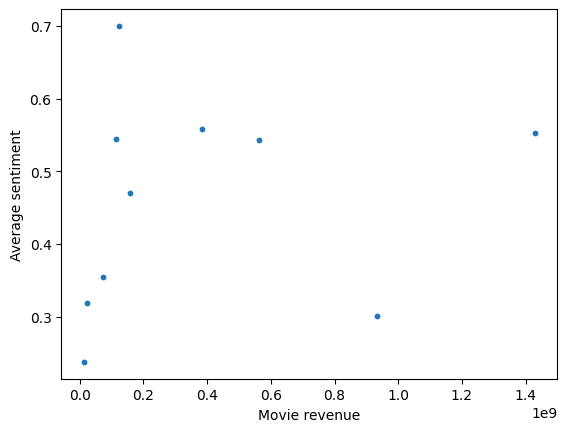

In [23]:
with open('datasets/40MoviesDataSet.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    movie_data = [row for row in csv_reader]

# only does the first 10 for now because I dont have the other comments yet
x =  [int(i['revenue']) for i in movie_data[:10]]
y =  [sentiment_by_movie_id[i['id']] for i in movie_data[:10]]

plt.scatter(x, y, s=10)

plt.xlabel("Movie revenue")
plt.ylabel("Average sentiment")

plt.show()